### Training two models in the same graph

In [2]:
from keras.layers import Conv2D, MaxPooling2D

import keras
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Input, Flatten, PReLU, LeakyReLU, BatchNormalization
from keras.optimizers import Adam, Adadelta
from time import time

import time as T
import numpy as np
import matplotlib.pyplot as plt

from utils.codifications import Fitness
from utils.codification_cnn import CNNLayer, ChromosomeCNN, NNLayer
from utils.utils import WarmUpCosineDecayScheduler, smooth_labels

class FitnessCNN_real_but_ommited(Fitness):

    def set_params(self, data, batch_size=128, epochs=100, early_stop=True, reduce_plateau=True, verbose=1,
                   reset=True, test=False, warm_epochs=0, base_lr=0.001, smooth_label=False, cosine_decay=True):
        self.smooth = smooth_label
        self.warmup_epochs = warm_epochs
        self.learning_rate_base = base_lr
        self.reset = reset
        self.test = test
        self.time = 0
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stop = early_stop
        self.reduce_plateu = reduce_plateau
        self.verb = verbose
        (self.x_train, self.y_train), (self.x_test, self.y_test), (self.x_val, self.y_val) = data
        self.input_shape = self.x_train[0].shape
        self.num_clases = self.y_train.shape[1]
        self.cosine_decay = cosine_decay
        if self.smooth > 0:
            self.y_train = smooth_labels(self.y_train, self.smooth)
        return self

    def set_callbacks(self):
        callbacks = []
        # Create the Learning rate scheduler.
        total_steps = int(self.epochs * self.y_train.shape[0] / self.batch_size)
        warm_up_steps = int(self.warmup_epochs * self.y_train.shape[0] / self.batch_size)
        base_steps = self.epochs * (not self.cosine_decay)
        warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=self.learning_rate_base,
                                                total_steps=total_steps,
                                                warmup_learning_rate=0.0,
                                                warmup_steps=warm_up_steps,
                                                hold_base_rate_steps=base_steps)
        callbacks.append(warm_up_lr)

        checkpoint_last = ModelCheckpoint('./tmp/model_last.hdf5')
        checkpoint_acc = ModelCheckpoint('./tmp/model_acc.hdf5', monitor='val_acc', save_best_only=True)
        checkpoint_loss = ModelCheckpoint('./tmp/model_loss.hdf5', monitor='val_loss', save_best_only=True)
        callbacks.append(checkpoint_acc)
        callbacks.append(checkpoint_loss)
        callbacks.append(checkpoint_last)

        if self.early_stop and keras.__version__ == '2.2.4':
            callbacks.append(EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True))
        elif self.early_stop:
            callbacks.append(EarlyStopping(monitor='val_acc', patience=10))
        if self.reduce_plateu:
            callbacks.append(ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                                               patience=5, verbose=self.verb))
        return []

    def calc(self, chromosome, test=False, lr=0.001):
        print(chromosome, end="")
        print("Training...", end=" ")
        try:
            ti = T.time()
            keras.backend.clear_session()
            callbacks = self.set_callbacks()
            model = self.decode(chromosome, lr=lr)
            h = model.fit(self.x_train, self.y_train,
                          batch_size=self.batch_size,
                          epochs=self.epochs,
                          verbose=self.verb,
                          validation_data=(self.x_val, self.y_val),
                          callbacks=callbacks)
            return h
            if test:
                score = 1 - model.evaluate(self.x_test, self.y_test, verbose=0)[1]
            else:
                score = 1 - np.max(h.history['val_acc'])
        except Exception as e:
            score = [1 / self.num_clases, 1. / self.num_clases]
            if isinstance(e, ResourceExhaustedError):
                print("ResourceExhaustedError\n")
            else:
                print("Some Error!")
                print(e, "\n")
            keras.backend.clear_session()
            T.sleep(5)
            return 1 - score[1]
        if self.verb:
            model = load_model('./tmp/model_last.hdf5')
            score_test = 1 - model.evaluate(self.x_test, self.y_test, verbose=0)[1]
            score_val = 1 - h.history['val_acc'][-1]
            print('Last -> Val acc: %0.4f,Test acc: %0.4f' % (score_val, score_test))

            model = load_model('./tmp/model_acc.hdf5')
            score_test = 1 - model.evaluate(self.x_test, self.y_test, verbose=0)[1]
            score_val = 1 - np.max(h.history['val_acc'])
            print('Acc -> Val acc: %0.4f,Test acc: %0.4f' % (score_val, score_test))

            model = load_model('./tmp/model_loss.hdf5')
            score_test = 1 - model.evaluate(self.x_test, self.y_test, verbose=0)[1]
            score_val = 1 - h.history['val_acc'][int(np.argmin(h.history['val_loss']))]
            print('Loss -> Val acc: %0.4f,Test acc: %0.4f' % (score_val, score_test))

            #dataset = ['Val', 'Test'][test]
            #print('%s loss: %0.4f,%s acc: %0.4f' % (dataset, score[0], dataset, score[1]))
            self.show_result(h, 'acc')
            self.show_result(h, 'loss')
        self.time += T.time() - ti
        print("%0.4f in %0.1f min\n" % (score, (T.time() - ti) / 60))
        return score
    
    def decode_c(self, chromosome, inp, name='c'):
        x = inp
        for i in range(chromosome.n_cnn):
            act = chromosome.cnn_layers[i].activation
            filters = chromosome.cnn_layers[i].filters
            ksize = chromosome.cnn_layers[i].k_size
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Conv2D(filters, ksize, activation=act, padding='same')(x)
            elif act == 'prelu':
                x = Conv2D(filters, ksize, padding='same')(x)
                x = PReLU()(x)
            else:
                x = Conv2D(filters, ksize, padding='same')(x)
                x = LeakyReLU()(x)
            x = BatchNormalization()(x)
            x = Dropout(chromosome.cnn_layers[i].dropout)(x)
            if chromosome.cnn_layers[i].maxpool:
                x = MaxPooling2D()(x)

        x = Flatten()(x)

        for i in range(chromosome.n_nn):
            act = chromosome.nn_layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.nn_layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.nn_layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.nn_layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.nn_layers[i].dropout)(x)
        x = Dense(self.num_clases, activation='softmax', name=name)(x)
        return x
    
    def decode(self, chromosome, lr=0.001):
        inputs = Input(shape=self.input_shape)
        model = Model(inputs=inputs, outputs= self.decode_c(chromosome, inputs, 'x1'), name="all_net")
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr),
                      metrics=['accuracy'])
        return model
    
    def decode_(self, chromosome, lr=0.001):
        inp = Input(shape=self.input_shape)
        x = inp

        for i in range(chromosome.n_cnn):
            act = chromosome.cnn_layers[i].activation
            filters = chromosome.cnn_layers[i].filters
            ksize = chromosome.cnn_layers[i].k_size
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Conv2D(filters, ksize, activation=act, padding='same')(x)
            elif act == 'prelu':
                x = Conv2D(filters, ksize, padding='same')(x)
                x = PReLU()(x)
            else:
                x = Conv2D(filters, ksize, padding='same')(x)
                x = LeakyReLU()(x)
            x = BatchNormalization()(x)
            x = Dropout(chromosome.cnn_layers[i].dropout)(x)
            if chromosome.cnn_layers[i].maxpool:
                x = MaxPooling2D()(x)

        x = Flatten()(x)

        for i in range(chromosome.n_nn):
            act = chromosome.nn_layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.nn_layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.nn_layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.nn_layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.nn_layers[i].dropout)(x)
        x = Dense(self.num_clases, activation='softmax')(x)

        model = Model(inputs=inp, outputs=x)
        if self.verb:
            model.summary()
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr),
                      metrics=['accuracy'])
        return model

    @staticmethod
    def show_result(history, metric='acc'):
        epochs = np.linspace(0, len(history.history['acc']) - 1, len(history.history['acc']))
        plt.plot(epochs, history.history['val_%s' % metric], label='validation')
        plt.plot(epochs, history.history[metric], label='train')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.show()

    def fitness_n_models(self, c1, c2):
        inputs = Input(shape=self.input_shape)
        model = Model(inputs=inputs, outputs=[self.decode_c(c1, inputs, 'x1'), self.decode_c(c2, inputs, 'x2')],
                      name="all_net")
        losses = {'x1': "categorical_crossentropy", 'x2': "categorical_crossentropy"}
        metrics = {'x1': 'accuracy',
                   'x2': 'accuracy'}
        model.compile(optimizer=Adam(), loss=losses, metrics=metrics)
        if self.verb:
            model.summary()
        h = model.fit(self.x_train, [self.y_train, self.y_train],
                  batch_size=self.batch_size,
                  epochs=self.epochs,
                  verbose=self.verb,
                  validation_data=(self.x_val, [self.y_val, self.y_val]))
        # callbacks=self.callbacks)
        return h

In [3]:
import tensorflow as tf
from keras import backend as K
from keras.datasets import mnist

class FitnessCNN(Fitness):
    
    def __init__(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
        config.log_device_placement = True  # to log device placement (on which device the operation ran)

        sess = tf.Session(config=config)
        keras.backend.set_session(sess)

        self.batch_size = 128
        self.num_classes = 10
        self.epochs = 5
        self.verb = 1

        # input image dimensions
        img_rows, img_cols = 28, 28

        # the data, split between train and test sets
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        if K.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)

        self.x_train = x_train.astype('float32')
        self.x_test = x_test.astype('float32')
        self.x_train /= 255
        self.x_test /= 255

        # convert class vectors to binary class matrices
        self.y_train = keras.utils.to_categorical(y_train, self.num_classes)
        self.y_test = keras.utils.to_categorical(y_test, self.num_classes)
        self.input_shape = self.x_train[0].shape

    def calc(self, chromosome, test=False, lr=0.001, fp=32):
        K.set_floatx("float%d" % fp)

        model = self.decode(chromosome, lr=lr)
        ti = time()
        h = model.fit(self.x_train, self.y_train,
                      batch_size=self.batch_size,
                      epochs=self.epochs,
                      verbose=self.verb,
                      validation_data=(self.x_test, self.y_test))
        
        score = model.evaluate(self.x_test, self.y_test, verbose=0)
        print("Training time: %0.4f" % (time() - ti))
        return score
    
    def decode_c(self, chromosome, inp, name='c'):
        x = inp
        for i in range(chromosome.n_cnn):
            act = chromosome.cnn_layers[i].activation
            filters = chromosome.cnn_layers[i].filters
            ksize = chromosome.cnn_layers[i].k_size
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Conv2D(filters, ksize, activation=act)(x)
            elif act == 'prelu':
                x = Conv2D(filters, ksize)(x)
                x = PReLU()(x)
            else:
                x = Conv2D(filters, ksize)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.cnn_layers[i].dropout)(x)
            if chromosome.cnn_layers[i].maxpool:
                x = MaxPooling2D()(x)

        x = Flatten()(x)

        for i in range(chromosome.n_nn):
            act = chromosome.nn_layers[i].activation
            if act in ['relu', 'sigmoid', 'tanh', 'elu']:
                x = Dense(chromosome.nn_layers[i].units, activation=act)(x)
            elif act == 'prelu':
                x = Dense(chromosome.nn_layers[i].units)(x)
                x = PReLU()(x)
            else:
                x = Dense(chromosome.nn_layers[i].units)(x)
                x = LeakyReLU()(x)
            x = Dropout(chromosome.nn_layers[i].dropout)(x)
        x = Dense(self.num_classes, activation='softmax', name=name)(x)
        return x
    
    def decode(self, chromosome, lr=0.001):
        inputs = Input(shape=self.input_shape)
        model = Model(inputs=inputs, outputs= self.decode_c(chromosome, inputs, 'x1'), name="all_net")
        
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adadelta(),
                      metrics=['accuracy'])
        model.summary()
        return model
    
    def fitness_n_models(self, c1, c2):
        inputs = Input(shape=self.input_shape)
        model = Model(inputs=inputs, outputs=[self.decode_c(c1, inputs, 'x1'), self.decode_c(c2, inputs, 'x2')],
                      name="all_net")
        losses = {'x1': "categorical_crossentropy", 'x2': "categorical_crossentropy"}
        metrics = {'x1': 'accuracy',
                   'x2': 'accuracy'}
        model.compile(optimizer=Adadelta(), loss=losses, metrics=metrics)
        model.summary()
        ti = time()
        h = model.fit(self.x_train, [self.y_train, self.y_train],
                  batch_size=self.batch_size,
                  epochs=self.epochs,
                  verbose=self.verb,
                  validation_data=(self.x_test, [self.y_test, self.y_test]))
        score = model.evaluate(self.x_test, [self.y_test, self.y_test], verbose=0)
        print("Training time: %0.4f" % (time() - ti))
        return h

In [4]:

fitness = FitnessCNN()
l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness)




###### Train a single CNN model take ~69.5 seconds

In [9]:
ti = time()
h1 = fitness.calc(c, fp=16)
print("Total elapsed time: %0.3f" % (time() - ti))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_13 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
__________

###### Train two identical models in the same graph take about 136 seconds.
 That is a 97.8 % of train 2 serial models.

In [5]:
ti = time()
h2 = fitness.fitness_n_models(c,c)
print("Total elapsed time: %0.3f" % (time() - ti))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 26, 26, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 26, 26, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 26, 26, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dropout_7 

In [2]:
import shlex, subprocess
import os
from time import time
import threading
import multiprocessing

class TEST:
    def __init__(self, com_line):
        self.com_line = com_line
        
    def tests(self):
        args = shlex.split(self.com_line)
        subprocess.call(args)
    
cl_base = 'python /home/daniel/repositories/keras/examples/mnist_cnn.py'
cl = [cl_base for _ in range(2)]

funcs = []
for c in cl:
    a = TEST(c)
    funcs.append(a.tests)

In [4]:
start_time = time()
funcs[0]()
end_time = time()
print("Single time=", end_time - start_time)
 
start_time = time()
threads = [threading.Thread(target=f) for f in funcs]
[thread.start() for thread in threads]
[thread.join() for thread in threads]
end_time = time()
 
print("Threads time=", end_time - start_time)

Single time= 67.85601210594177
Threads time= 130.66771245002747


In [1]:
from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN
from utils.codifications import Fitness
from utils.datamanager import DataManager
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA
from time import time

class Fitness_str(Fitness):
    def set_params(self, c, **args):
        self.c = c
        self.str = c.__repr__()
        self.time = 0
        
    def calc(self, c, test=False):
        ti = time()
        c_str = c.__repr__()
        f = max(len(self.str), len(c_str)) - min(len(self.str), len(c_str))
        for i in range(min(len(self.str), len(c_str))):
            f += self.str[i]!= c_str[i]
        self.time += time() - ti
        return f
    
mutation_rate = 0.05
mutation_rate_1 = mutation_rate * 2
ChromosomeCNN.grow_prob = mutation_rate
ChromosomeCNN.decrease_prob = mutation_rate

CNNLayer.k_prob = mutation_rate
CNNLayer.filter_prob = mutation_rate_1
CNNLayer.act_prob = mutation_rate
CNNLayer.drop_prob = mutation_rate_1
CNNLayer.maxpool_prob = mutation_rate

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1
    
fitness = Fitness_str()
l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness)
fitness.set_params(c)




# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = 0.25
generations = 100
population = 1000
train_time = 60
maximize_fit = False
stat_val=False
folder = "../delete"
save_progress = False
age_survivors_rate = 0.2

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(population//4)}
p = ps[parents_selector_key]



generational = GenerationalGA(fitness=fitness, num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, maximize_fitness=maximize_fit, 
                              training_hours=train_time, folder=folder, statistical_validation=stat_val,
                             save_progress=save_progress, age_survivors_rate=age_survivors_rate)

Using TensorFlow backend.


Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 100
Population size: 1000
num parents: 250
offspring size: 750



Creating Initial population

Start evolution process...

1) best fit: 46.000 in batch time: 0.00 mins
Current winner:
CNN|F:60|K:(7,7)|A:tanh|D:0.108|M:0
CNN|F:127|K:(1,3)|A:elu|D:0.443|M:0
NN|U:255|A:sigmoid|D:0.410

11) best fit: 14.000 in batch time: 0.05 mins
Current winner:
CNN|F:88|K:(5,5)|A:relu|D:0.444|M:0
CNN|F:65|K:(5,3)|A:relu|D:0.610|M:1
NN|U:528|A:relu|D:0.513

21) best fit: 9.000 in batch time: 0.10 mins
Current winner:
CNN|F:65|K:(3,3)|A:relu|D:0.485|M:0
CNN|F:84|K:(1,3)|A:relu|D:0.250|M:1
NN|U:526|A:relu|D:0.500

31) best fit: 8.000 in batch time: 0.16 mins
Current winner:
CNN|F:38|K:(3,3)|A:relu|D:0.405|M:0
CNN|F:62|K:(3,3)|A:relu|D:0.256|M:1
NN|U:750|A:relu|D:0.500

41) best fit: 6.000 in batch time: 0.21 mins
Current winner:
CNN|F:38|K:(3,3)|A:relu|D:0.384|M:0
CNN|F:64|K:(3,3)|A:relu|D:0.250|M:1
NN|U:578|A:relu|D:0.500

51) best fit: 5.000 in batch time: 0.26 mins
Current winner:
CNN|F:59|K:(3,3)|A:relu|D:0.400|M:0
CNN|F:64|K:(3,3)|A:relu|D:0.250|M:1
NN|U:598|A:relu|

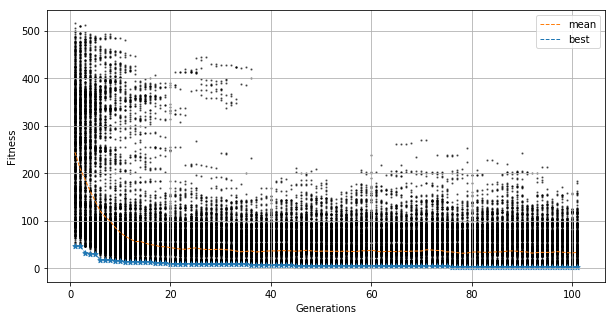

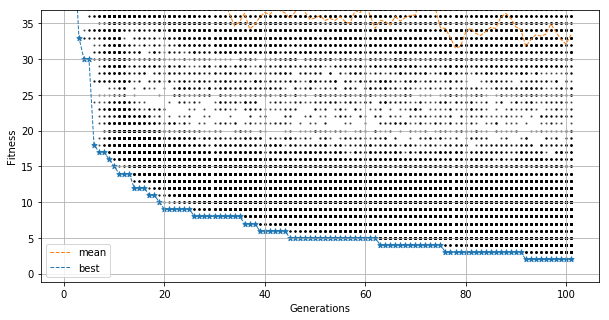

Total elapsed time: 37.000
Total training time: 0.939


In [2]:
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
print("Total training time: %0.3f" % fitness.time)

In [3]:
import os

s = c.__repr__()
print(s)

filename = '../delete/gen_example.txt'
with open(filename, 'w') as f:
    f.write(s)
    f.write("Score: 1322")
    
fitness = FitnessCNN()
# Fitness params
epochs = 5
batch_size = 128
verbose = 1
redu_plat = False
early_stop = 15
warm_up_epochs= 1
base_lr = 0.001
smooth = 0.1
cosine_dec = False
fitnes_file = '../delete/fitness_example'    

# dataset params:
dataset = 'MRD'
data_folder = '../../../../../datasets/MNIST_variations'
classes = []

# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()
fitness.set_params(data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth)

fitness.save(fitnes_file)

CNN|F:32|K:(3,3)|A:relu|D:0.000|M:0
CNN|F:64|K:(3,3)|A:relu|D:0.250|M:1
NN|U:128|A:relu|D:0.500

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples


In [4]:

fit = FitnessCNN.load(fitnes_file)

Training... _________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 64)        0        

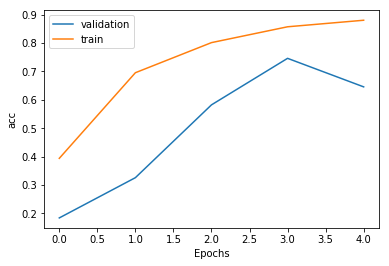

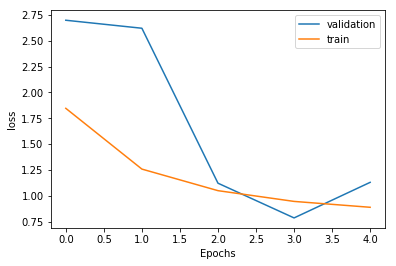

0.2542 in 2.1 min

Total elapsed time: 126.842


In [5]:
ti = time()
h1 = fit.calc(c)
print("Total elapsed time: %0.3f" % (time() - ti))

In [79]:
import subprocess, re

# Nvidia-smi GPU memory parsing.
# Tested on nvidia-smi 370.23

def run_command(cmd):
    """Run command, return output as string."""
    output = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True).communicate()[0]
    return output.decode("ascii")

def list_available_gpus():
    """Returns list of available GPU ids."""
    output = run_command("nvidia-smi -L")
    # lines of the form GPU 0: TITAN X
    gpu_regex = re.compile(r"GPU (?P<gpu_id>\d+):")
    result = []
    for line in output.strip().split("\n"):
        m = gpu_regex.match(line)
        assert m, "Couldnt parse "+line
        result.append(int(m.group("gpu_id")))
    return result

def gpu_memory_map():
    """Returns map of GPU id to memory allocated on that GPU."""

    output = run_command("nvidia-smi")
    print(output)
    gpu_output = output[output.find("GPU Memory"):]
    # lines of the form
    # |    0      8734    C   python                                       11705MiB |
    memory_regex = re.compile(r"[|]\s+?(?P<gpu_id>\d+)\D+?(?P<pid>\d+).+[ ](?P<gpu_memory>\d+)MiB")
    rows = gpu_output.split("\n")
    result = {gpu_id: 0 for gpu_id in list_available_gpus()}
    for row in gpu_output.split("\n"):
        print(row)
        m = memory_regex.search(row)
        if not m:
            continue
        gpu_id = int(m.group("gpu_id"))
        gpu_memory = int(m.group("gpu_memory"))
        
        result[gpu_id] += gpu_memory
    return result

def gpu_memory_maps():
    """Returns map of GPU id to memory allocated on that GPU."""

    output = run_command("nvidia-smi -q  -d MEMORY")
    atacched_gpus = 0
    for row in output.split('\n'):
        if 'Attached GPUs' in row:
            atacched_gpus = int(row.split(':')[1])
    info_gpu = output.split('GPU ')[1:]
    assert len(info_gpu) == atacched_gpus
    gpu_dict_free_memory = {}
    for gpu_id, info in enumerate(info_gpu):
        gpu_dict = {}
        line = info.split('BAR')[0].split('FB')[1].split('\n')
        line = [l.replace(" ","") for l in line if ':' in l]
        for sub_line in line:
            key, val = sub_line.split(':')
            gpu_dict[key] = int(val.split('MiB')[0])
        gpu_dict_free_memory[gpu_id] = gpu_dict['Free'] * 100. / gpu_dict['Total']
    return gpu_dict_free_memory
                
def pick_gpu_lowest_memory():
    """Returns GPU with the least allocated memory"""

    memory_gpu_map = [(memory, gpu_id) for (gpu_id, memory) in gpu_memory_map().items()]
    best_memory, best_gpu = sorted(memory_gpu_map)[0]
    return best_gpu


a = gpu_memory_maps()

for k,v in a.items():
    print(k,v)

0 6.434050977480822


In [85]:
output = run_command('python /home/daniel/repositories/keras/examples/mnist_siamese.py')


In [10]:
gpu_output = output[output.find("GPU Memory"):]
print(gpu_output)

GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      1196      G   /usr/lib/xorg/Xorg                           271MiB |
|    0      2140      G   compiz                                       115MiB |
|    0      3649      G   /opt/teamviewer/tv_bin/TeamViewer             24MiB |
|    0      4249      G   ...pycharm-professional/132/jre64/bin/java     2MiB |
+-----------------------------------------------------------------------------+



In [1]:
from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA
from time import time
import numpy as np

Using TensorFlow backend.


In [11]:
fitness = FitnessCNN()
# Fitness params
epochs = 75
batch_size = 128
verbose = 1
redu_plat = False
early_stop = 15
warm_up_epochs= 1
base_lr = 0.001
smooth = 0.1
cosine_dec = True
fitness_file = '../delete/fitness_example'    

# dataset params:
dataset = 'MBI'
data_folder = '../../../../../datasets/MNIST_variations'
classes = []

# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()
fitness.set_params(data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth)

fitness.save(fitness_file)

del dm, data, fitness

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples


In [12]:
fitness_folder = '../delete'
fitness_file = '../delete/fitness_example'    

fitness = FitnessCNNParallel()
fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=1,
                   fp=16, main_line='python /home/daniel/proyectos/Tesis/project/GA/NeuroEvolution/train_gen.py')

In [13]:
l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c1 = ChromosomeCNN([l, l2], [l3], fitness)
c2 = ChromosomeCNN([], [], fitness)
c3 = ChromosomeCNN([CNNLayer(32, (3,3), 'relu', 0, True)], [NNLayer(512, 'relu', 0.5)], fitness)

c_list = [c1, c1, c1, c1, c1]

In [15]:
ti = time()
s = fitness.calc(c1, test=True)
print(s)
print("Elapsed time: %0.4f" % (time() - ti))

0.05158
Elapsed time: 72.5177


In [31]:
ti = time()
s = fitness.calc(c1, test=True)
print(s)
print("Elapsed time: %0.4f" % (time() - ti))

0.22466
Elapsed time: 79.1630


In [26]:
ti = time()

scores = fitness.eval_list(c_list)
print(scores)
print("Elapsed time: %0.4f" % (time() - ti))

KeyboardInterrupt: 

In [ ]:
scores

In [21]:
import numpy as np

scores32_BN32 = scores
print(scores32_BN32)
print("mean %0.4f, std %0.f4" % (np.mean(scores32_BN32), np.std(scores32_BN32)))
print("Elapsed time: %0.4f" % (time() - ti))

[0.9, 0.20264, 0.23244, 0.23744, 0.23886]
mean 0.3623, std 04
Elapsed time: 157.1789


In [43]:
import numpy as np

In [47]:
a = np.array([1])

In [48]:
a.dtype


dtype('int64')